In [ ]:
# 2차원 배열의 크기가 변할때, 베타에 따른 에너지의 그래프, 베타에 따른 m의 그래프가 어떻게 달라지는지 볼 것이다.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series

# 과정

## 이전 과제에서 만든 함수 (수정)

1.   total_energy개선 적용
2.   새로운 베타에서 실행할 때, (랜덤으로 초기화 하지 않고) 이전 베타에서의 어레이 사용

In [ ]:
def local(L,num):

  right = num+1
  if right % L == 0:
    right -= L

  left = num-1
  if (left+1) % L == 0:
    left += L

  up = num - L
  if up < 0:
    up += L*L

  down = num + L
  if down >= L*L:
    down -= L*L

  return np.array([right,up,left,down])

def local_E(arr, num):
  L=int(np.sqrt(len(arr)))
  return -np.sum(arr[local(L,num)])*arr[num]

# def total_energy(S): # 이 함수는 "첫 시행에서만 사용"하는 것으로 변경 (전체를 계산)
#   L=int(np.sqrt(len(S)))
#   E=0
#   for num in range(len(S)):
#     E += (local_E(S, num))
#   return E/2

def total_energy(S): #for문 없앰 (이전 과제에서 for문을 이용한 함수의 값과 똑같이 나오는 것을 확인함)
  L=int(np.sqrt(len(S)))
  SS = S.reshape(L,L)

  SS1 = np.insert(SS, 0, SS[L-1,:], axis = 0)
  SS1 = np.delete(SS1, L, axis = 0)

  SS2 = np.insert(SS, L, SS[0,:], axis = 0)
  SS2 = np.delete(SS2, 0, axis = 0)

  SS3 = np.insert(SS, 0, SS[:,L-1], axis = 1)
  SS3 = np.delete(SS3, L, axis = 1)

  SS4 = np.insert(SS, L, SS[:,0], axis = 1)
  SS4 = np.delete(SS4, 0, axis = 1)

  SS_sum = SS1+SS2+SS3+SS4
  return -np.sum(SS * SS_sum)/2

def delta_E(arr, number):
  L=int(np.sqrt(len(arr)))
  return 2*(arr[number]) * np.sum(arr[local(L,number)])

In [ ]:
def spin_E_change(beta,L,t,prepared_arr=None):

  delta_m4 = np.exp(beta*(-4)) # 미리계산
  delta_m8 = np.exp(beta*(-8)) # 미리계산

  if prepared_arr:
    S = np.array(prepared_arr)
  else:
    random_arr = np.random.randn(L*L)
    S = random_arr/abs(random_arr)

  E_S = total_energy(S)
  m = np.sum(S)/len(S)

  E_list=[E_S]
  m_list=[m]
  S_list=[S]

  for t in range(t):
      U = S.copy()
      number = np.random.choice(len(S))
      U[number] *= -1

      # delta
      delta = delta_E(S, number) # delta == (-E_S+E_U)
      E_U = E_S + delta

      # accept 확률
      if delta <= 0:
        accept_S_to_U = 1
      else:
        if delta == 4:
          accept_S_to_U = delta_m4
        elif delta == 8:
          accept_S_to_U = delta_m8
        else:
          print('error, delta=',delta)

      # accept, 그다음 S 확정, 측정
      if np.random.random() < accept_S_to_U:
        S = U.copy()
        E_S = E_U.copy()
      m = np.sum(S)/len(S)

      E_list.append(E_S)
      m_list.append(m)
      S_list.append(S)

  return E_list, m_list, S_list

## 0.35~0.55구간에서 자세하게 그래프가 그려지도록 범위를 설정 (L=5일때의 경우)

In [ ]:
print(np.array(range(4))*0.1)
print(np.array(range(1,22))*0.01+0.34) #0.35~0.55는 0.01 간격
print(np.array(range(5))*0.1+0.6)

beta_list = list(np.array(range(4))*0.1) + list(np.array(range(1,22))*0.01+0.34) + list(np.array(range(5))*0.1+0.6)

[0.  0.1 0.2 0.3]
[0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42 0.43 0.44 0.45 0.46 0.47 0.48
 0.49 0.5  0.51 0.52 0.53 0.54 0.55]
[0.6 0.7 0.8 0.9 1. ]


In [ ]:
L=5
t=10500

In [ ]:
E_m_list, m_m_list = [],[]
E_lists=[]##표본 저장

for beta in beta_list:

  E_list, m_list, S_list = spin_E_change(beta, L, t)

  E_mean = np.sum(E_list[500:])/(t-500)
  m_mean = np.sum(m_list[500:])/(t-500)

  E_m_list.append(E_mean)
  m_m_list.append(m_mean)
  E_lists.append(E_list[500:]) #500부터~로 잘라서 저장

Text(0, 0.5, 'E_mean')

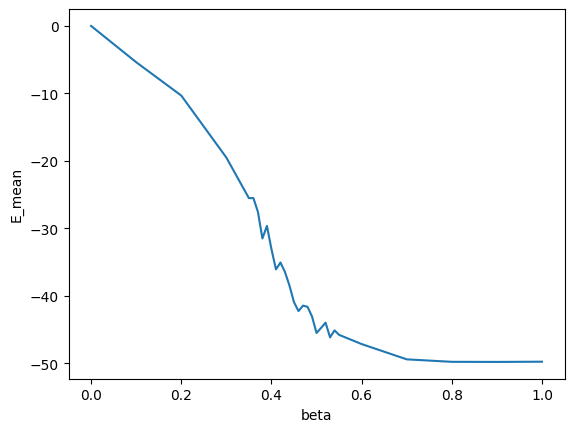

In [ ]:
plt.plot(beta_list, E_m_list)

plt.xlabel('beta')
plt.ylabel('E_mean')

In [ ]:
#표준오차

std_list=[]
for E_list in E_lists[::]:
    x_list = E_list[500:]
    S = Series(x_list)
    s_list=[]
    for i in range(500):
      s_list.append(S.autocorr(i))

    for i in range(len(s_list)):
      if s_list[i] < 0.1:
        tau = i*5 #i번째에 0.1보다 작은 상관계수
        break
      if i == len(s_list)-1:
        print('error 0.1보다 작은 상관계수가 없음')

    print(tau)
    sample = E_list[500:][::tau]
    s_std = np.std(sample)
    s_stderror = s_std/np.sqrt(len(sample)-1)
    print(s_stderror)

    std_list.append(s_stderror)

75
0.6717519484743891
105
0.7830264741912022
210
1.2368357428957297
560
2.498442421364153
645
3.1439536326804256
1090
3.2279642325186555
870
3.5887795757019125
730
2.54565841504532
990
2.4000000000000004
1420
4.250650210365981
1035
4.6571331190861285
900
3.256525553052816
1110
1.6923940235253128
685
2.763293827780521
730
3.501961773597231
1020
1.7688665548562135
775
1.7897362427297587
895
2.6473126870110972
575
1.9115384481496376
310
0.9804187627737905
430
1.4635398144401892
1055
1.3333333333333333
550
1.160972722152916
480
1.7038655741392401
680
1.1991624497321973
480
0.7341303483857975
350
0.0
190
0.0
455
0.0
405
0.33333333333333337


<ErrorbarContainer object of 3 artists>

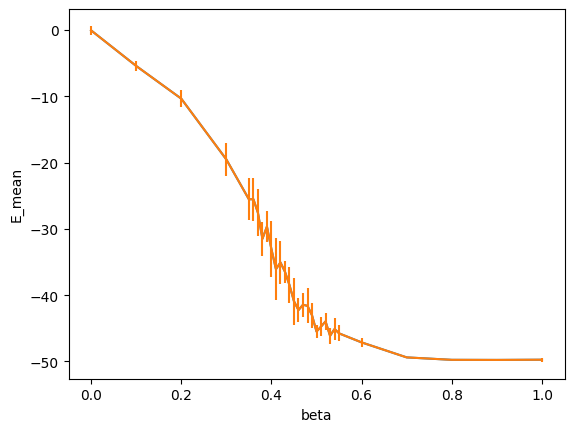

In [ ]:
plt.plot(beta_list, E_m_list)

plt.xlabel('beta')
plt.ylabel('E_mean')

plt.errorbar(beta_list[::], E_m_list[::], std_list)

## L=5,10,20 비교

In [ ]:
#E_mean_vs_beta 와 m_mean_vs_beta 둘 다 계산

def E_mean_m_mean_vs_beta(L,t,cut,find_tau_time = t):
    E_m_list, m_m_list = [],[]
    E_lists, m_lists = [],[] ##표본 저장

    beta_list = list(np.array(range(4))*0.1) + list(np.array(range(1,22))*0.01+0.34) + list(np.array(range(5))*0.1+0.6)
    prepared_arr = None
    for beta in beta_list:
      print('{:.2f}'.format(beta), end=',')
      E_list, m_not_abs, S_list = spin_E_change(beta, L, t, prepared_arr)
      m_abs = np.abs(m_not_abs)

      E_mean = np.sum(E_list[cut:])/(t-cut)
      m_mean = np.sum(m_abs[cut:])/(t-cut)

      E_m_list.append(E_mean)
      m_m_list.append(m_mean)

      E_lists.append(E_list[cut:]) #cut부터 잘라서 저장
      m_lists.append(m_not_abs[cut:]) #cut부터 잘라서 저장

      prepared_arr = list(S_list[-1])

    print('',end='\n')

    #tau 구하기
    E_std_list, m_std_list = [],[]
    for i in range(len(E_lists)):
        print('({}/{})'.format(i,len(E_lists)), end=',')
        E_l = E_lists[i]
        S = Series(E_l)
        tau=find_tau_time
        for j in range(find_tau_time):
          if S.autocorr(j) < 0.1:
            tau = j*3
            tau_error = True
            break

        #E에 대한 표준오차 구하기
        sample_E = E_l[tau::tau]
        std_E = np.std(sample_E)
        stderror_E = std_E/np.sqrt(len(sample_E)-1)
        E_std_list.append(stderror_E)

        #m에 대한 표준오차 구하기
        m_l = m_lists[i]

        sample_m = m_l[tau::tau]
        std_m = np.std(sample_m)
        stderror_m = std_m/np.sqrt(len(sample_m)-1)
        m_std_list.append(stderror_m)



    plt.plot(beta_list, E_m_list)
    plt.xlabel('beta')
    plt.ylabel('E_mean')
    plt.errorbar(beta_list, E_m_list, E_std_list)
    plt.show()

    plt.plot(beta_list, m_m_list)
    plt.xlabel('beta')
    plt.ylabel('m_mean')
    plt.errorbar(beta_list, m_m_list, m_std_list)
    plt.show()

    return beta_list, E_m_list, m_m_list, E_std_list, m_std_list

### L=5

0.00,0.10,0.20,0.30,0.35,0.36,0.37,0.38,0.39,0.40,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.50,0.51,0.52,0.53,0.54,0.55,0.60,0.70,0.80,0.90,1.00,
(0/30),(1/30),(2/30),(3/30),(4/30),(5/30),(6/30),(7/30),(8/30),(9/30),(10/30),(11/30),(12/30),(13/30),(14/30),(15/30),(16/30),(17/30),(18/30),(19/30),(20/30),(21/30),(22/30),(23/30),(24/30),(25/30),(26/30),(27/30),(28/30),(29/30),

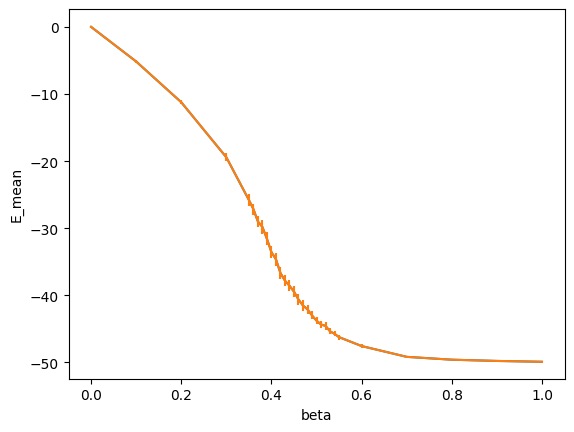

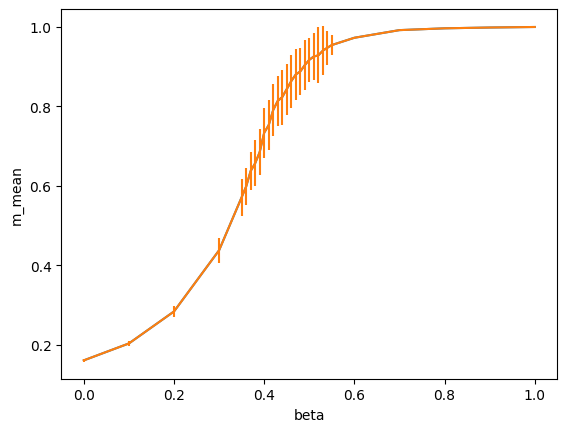

In [ ]:
L=5
t=100000
cut = 500

beta_list_0, E_m_list_0, m_m_list_0, E_std_list_0, m_std_list_0 = E_mean_m_mean_vs_beta(L,t,cut)

### L=10

0.00,0.10,0.20,0.30,0.35,0.36,0.37,0.38,0.39,0.40,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.50,0.51,0.52,0.53,0.54,0.55,0.60,0.70,0.80,0.90,1.00,
(0/30),(1/30),(2/30),(3/30),(4/30),(5/30),(6/30),(7/30),(8/30),(9/30),(10/30),(11/30),(12/30),(13/30),(14/30),(15/30),(16/30),(17/30),(18/30),(19/30),(20/30),(21/30),(22/30),(23/30),(24/30),(25/30),(26/30),(27/30),(28/30),(29/30),

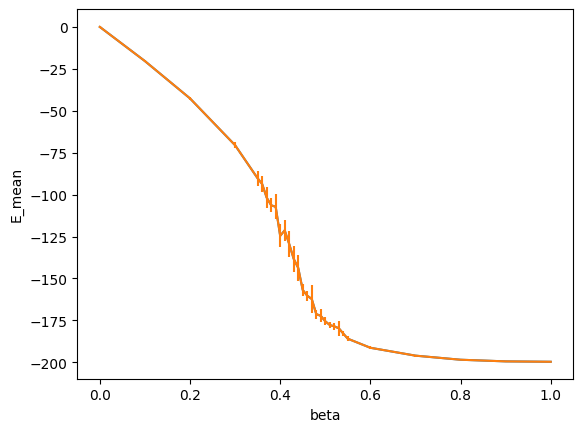

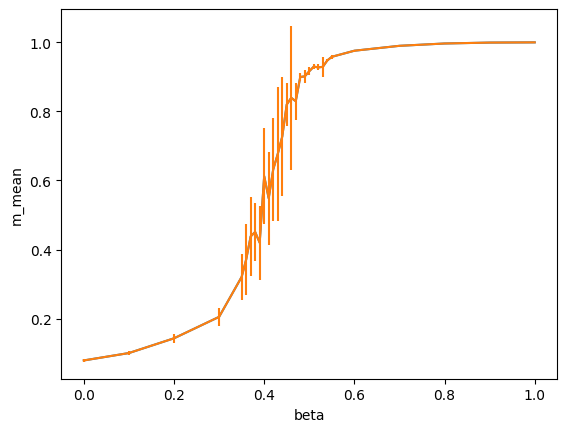

In [ ]:
L=10
t=100000
cut = 500

beta_list_1, E_m_list_1, m_m_list_1, E_std_list_1, m_std_list_1 = E_mean_m_mean_vs_beta(L,t,cut)

### L=20

0.00,0.10,0.20,0.30,0.35,0.36,0.37,0.38,0.39,0.40,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.50,0.51,0.52,0.53,0.54,0.55,0.60,0.70,0.80,0.90,1.00,
(0/30),(1/30),(2/30),(3/30),(4/30),(5/30),(6/30),(7/30),(8/30),(9/30),(10/30),(11/30),(12/30),(13/30),(14/30),(15/30),(16/30),(17/30),(18/30),(19/30),(20/30),(21/30),(22/30),(23/30),(24/30),(25/30),(26/30),(27/30),(28/30),(29/30),

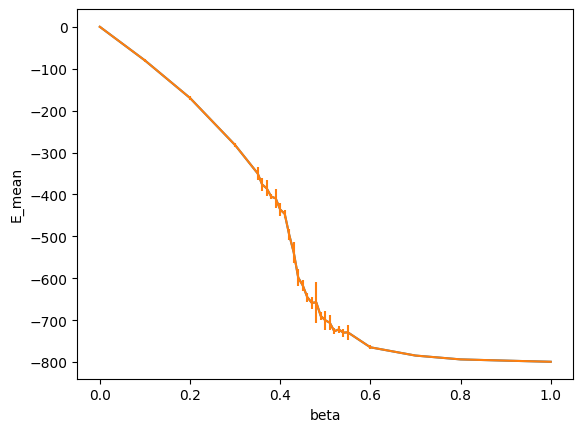

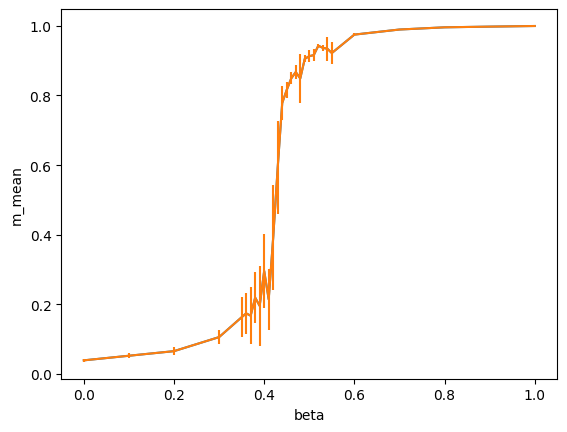

In [ ]:
L=20
t=100000
cut = 500

beta_list_2, E_m_list_2, m_m_list_2, E_std_list_2, m_std_list_2 = E_mean_m_mean_vs_beta(L,t,cut)

# L=5,10,20

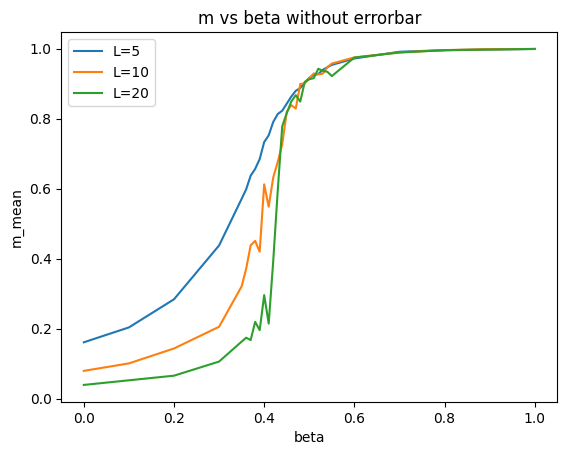

In [ ]:
plt.plot(beta_list_0, m_m_list_0, label='L=5')
plt.plot(beta_list_1, m_m_list_1, label='L=10')
plt.plot(beta_list_2, m_m_list_2, label='L=20')
plt.xlabel('beta')
plt.ylabel('m_mean')
plt.title('m vs beta without errorbar')
plt.legend()

#베타가 커질수록 극성이 생기는 지점에서 기울기가 커진다.

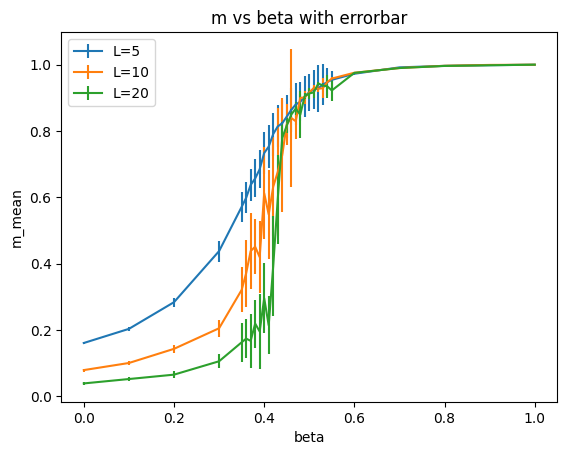

In [ ]:
plt.errorbar(beta_list_0, np.abs(m_m_list_0), m_std_list_0, label='L=5')
plt.errorbar(beta_list_1, np.abs(m_m_list_1), m_std_list_1, label='L=10')
plt.errorbar(beta_list_2, np.abs(m_m_list_2), m_std_list_2, label='L=20')
plt.xlabel('beta')
plt.ylabel('m_mean')
plt.title('m vs beta with errorbar')
plt.legend()
#m도 베타가 커질수록 극성이 생기는 지점에서 기울기가 커진다.